In [1]:
from load_data import data, data_path, xu_masses, phi_masses, mc_names

Loading data from /home/c.rodriguez45/github/U1T3R_Significances/data
Done!


In [2]:
import scipy.stats as stats

model = stats.alpha
xu_mass = xu_masses[0]
phi_mass = phi_masses[4]
mc = mc_names[1]
tail_uncert = 0.03
global_weight = 1 #- 0 * tail_uncert
print(f"Model: {model.name}")
print(f"Xu Mass: {xu_mass}")
print(f"Phi Mass: {phi_mass}")
print(f"MC: {mc}")
print(f"Tail Uncertainty: {tail_uncert*100}%")

Model: alpha
Xu Mass: 500
Phi Mass: 100
MC: ttbarmumu
Tail Uncertainty: 3.0%


In [3]:
import pandas as pd

df_name = f"xu_{xu_mass}_phi_{phi_mass}"
df = pd.DataFrame(data[df_name])


def inv(x: float) -> float:
    return 1.0 - x


if mc != "signal":
    df = df.apply(inv)
df.head()

,signal,ttbarmumu,ttbarmumumunu
0,1.000000,0.000000,0.000000
1,0.931120,0.001206,0.056473
2,0.969251,0.000000,0.000000
3,0.984145,0.000000,0.040509
4,1.000000,0.000000,0.003408


In [4]:
import ROOT

n_bins = 50
title = f"m_{{\chi u}}={xu_mass}GeV, m_{{\phi}}={phi_mass}GeV"
histo = ROOT.TH1F(mc, title, n_bins, 0, 1)
canvas = ROOT.TCanvas("canvas", "canvas", 800, 600)
canvas.SetLogy()
[histo.Fill(x) for x in df[mc]]
n_events = histo.Integral()
histo.Scale(1 / histo.Integral())

Welcome to JupyROOT 6.30/04


In [5]:
n_empty_bins = sum(
    [1 for i in range(n_bins) if histo.GetBinContent(i + 1) == 0]
)
print(f"n_empty_bins: {n_empty_bins}")

n_empty_bins: 0


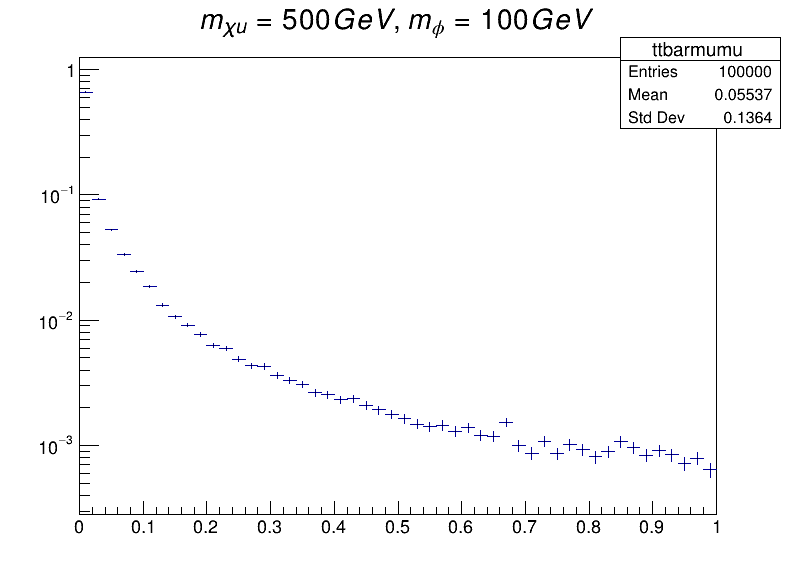

In [6]:
histo.Draw()
canvas.Draw()

fit bin:  39 threshold:  0.78


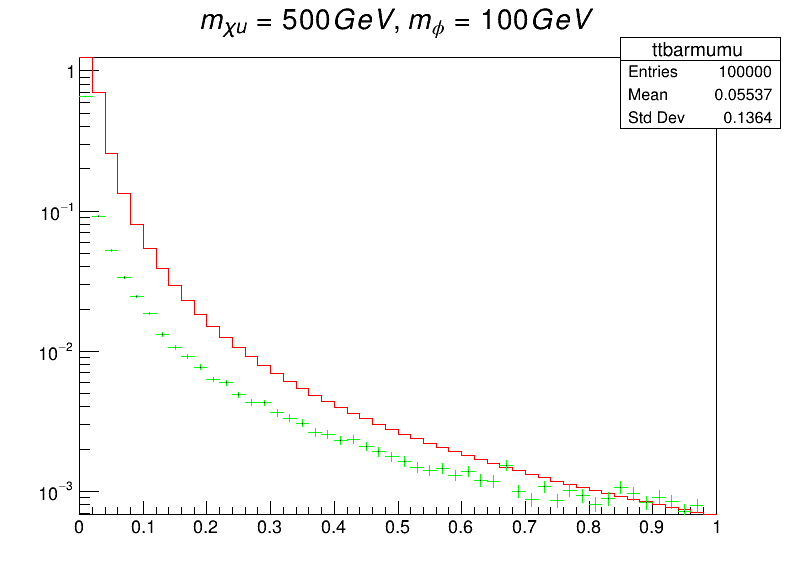

In [7]:
params = model.fit(df[mc])

x = [histo.GetBinCenter(bin + 1) for bin in range(n_bins)]
inter_histo = ROOT.TH1F("inter_histo", title, n_bins, 0, 1)
fill_inter_histo = [
    inter_histo.SetBinContent(bin + 1, model.pdf(x[bin], *params))
    for bin in range(n_bins)
]
# scale by the tail normalization
fit_bin = 0
aux_histo = ROOT.TH1F("aux_histo", title, n_bins, 0, 1)
bin_width = histo.GetBinWidth(1)
# get the first bin where the tail have a relative error greater
# than tail_uncert
for bin in range(n_bins):
    threshold = 0 + bin * bin_width
    [
        aux_histo.Fill(histo.GetBinCenter(bin + 1))
        for x in df[mc]
        if x > threshold
    ]
    I = aux_histo.GetBinContent(bin + 1)
    err = aux_histo.GetBinError(bin + 1)
    if err / I >= tail_uncert:
        fit_bin = bin
        break
print("fit bin: ", fit_bin, "threshold: ", threshold)

inter_histo.Scale(
    histo.Integral(fit_bin + 1, histo.GetNbinsX())
    / inter_histo.Integral(fit_bin + 1, inter_histo.GetNbinsX())
)
inter_histo.SetLineColor(ROOT.kRed)
histo.SetMinimum(inter_histo.GetMinimum())
histo.SetLineColor(ROOT.kGreen)
inter_histo.Draw("hist same")
histo.Draw("same")
canvas.Draw()

In [8]:
new_histo = ROOT.TH1F("new_histo", title, n_bins, 0, 1)


for bin in range(n_bins):
    if bin < fit_bin:
        new_histo.SetBinContent(bin + 1, histo.GetBinContent(bin + 1))
    elif histo.GetBinContent(bin + 1) == 0:
        new_histo.SetBinContent(bin + 1, inter_histo.GetBinContent(bin + 1))
    else:
        I = histo.GetBinContent(bin + 1)
        err = histo.GetBinError(bin + 1)
        weight = global_weight * err / I

        original_weight = (1 - weight)
        inter_weight = 11*weight

        original_weight, inter_weight = (
            original_weight / (original_weight + inter_weight),
            inter_weight / (original_weight + inter_weight),
        )
        new_histo.SetBinContent(
            bin + 1,
            histo.GetBinContent(bin + 1) * (original_weight)
            + inter_histo.GetBinContent(bin + 1) * (inter_weight),
        )
print("The tail has been replaced by the fit")
print(f"Integral: {new_histo.Integral()}")

The tail has been replaced by the fit
Integral: 1.0000072518596426


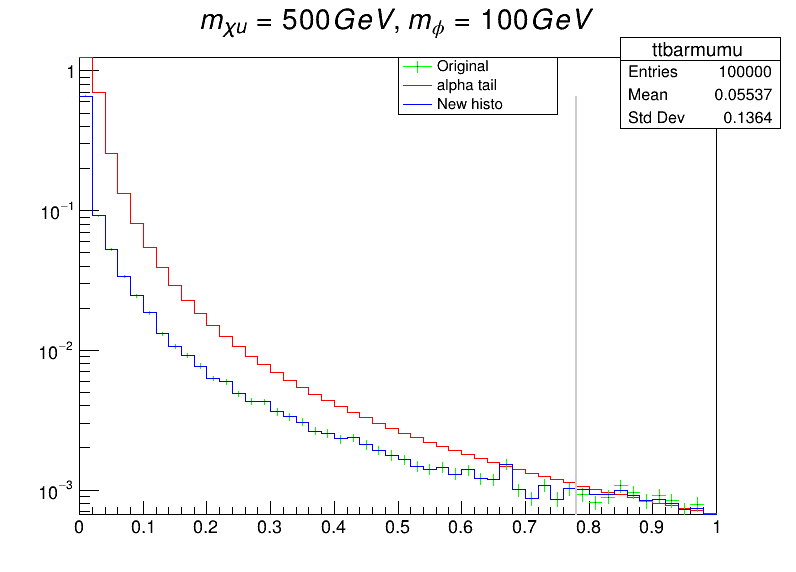

In [9]:
new_histo.SetLineColor(ROOT.kBlue)

new_histo.Scale(1 / new_histo.Integral())
new_histo.Draw("hist same")
histo.SetMinimum(min(histo.GetMinimum(), new_histo.GetMinimum()))
legend = ROOT.TLegend(0.5, 0.8, 0.7, 0.9)
legend.AddEntry(histo, "Original", "lep")
legend.AddEntry(inter_histo, f"{model.name} tail", "l")
legend.AddEntry(new_histo, "New histo", "l")
# Draw Threshold
line = ROOT.TLine(threshold, 0, threshold, histo.GetMaximum())
line.SetLineColor(ROOT.kGray)
line.SetLineWidth(2)
line.Draw()
legend.Draw()
canvas.Draw()

In [10]:
# Save histogram in dat file
import numpy as np
import os

histo_dat = np.array(
    [
        (
            [new_histo.GetBinCenter(bin + 1), new_histo.GetBinContent(bin + 1)]
            if mc == "signal"
            else [
                new_histo.GetBinCenter(n_bins - bin),
                1-new_histo.GetBinContent(n_bins - bin),
            ]
        )
        for bin in range(n_bins)
    ]
)
hist_dir = os.path.join(
    data_path,
    f"xu_{xu_mass}_GeV",
    f"phi_{phi_mass}_GeV",
    f"{mc}_hist.dat",
)
np.savetxt(hist_dir, histo_dat)
plt_dir = hist_dir.replace("data", "images").replace(".dat", ".png")
# create directory if it does not exist
os.makedirs(os.path.dirname(plt_dir), exist_ok=True)
canvas.SaveAs(plt_dir)
canvas.SaveAs(os.path.join(os.getcwd(), "last_plot.png"))

Info in <TCanvas::Print>: png file /home/c.rodriguez45/github/U1T3R_Significances/images/xu_500_GeV/phi_100_GeV/ttbarmumu_hist.png has been created
Info in <TCanvas::Print>: png file /home/c.rodriguez45/github/U1T3R_Significances/last_plot.png has been created


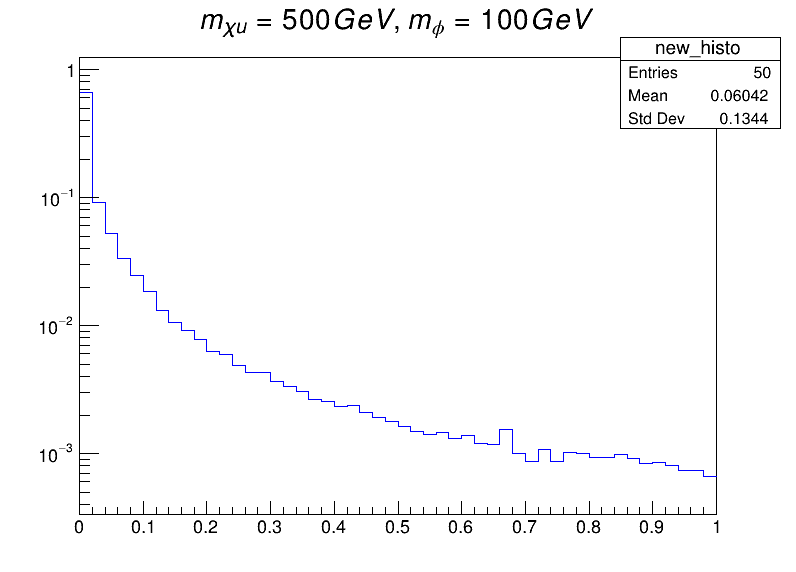

In [11]:
new_histo.Draw("hist")
canvas.Draw()